<a href="https://colab.research.google.com/github/NiklasTR/sirt3/blob/main/notebooks/diffdock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

colab by [@btnaughton](https://twitter.com/btnaughton)

In [1]:
#@title PDB + SMILES input

PDB_id = '6ej2' #@param {type:"string"}
SMILES_or_pubchem_id = 'CCCCNC(=O)[C@H](C)C[C@H](O)[C@@H]2C[C@H](C)CCCCCN(CC)C(=O)c1cc(cc(c1)C(=O)N2)OCC' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

In [2]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

In [3]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

## Importing protein-ligand pairs for affinity ranking

In [24]:
%cd /
!git clone https://github.com/labdao/sirt3.git
%cd /sirt3
!git pull
!git submodule init
!git submodule update
%cd /sirt3/lib/diffdock
!git submodule init
!git submodule update
!pwd

Streaming output truncated to the last 5000 lines.
 create mode 100644 data/processed/affinity_ranking/BACE1/index135_-tmp-pdb-6ej2.pdb____COCc1cc3cc(c1)C(=O)N[C@@H](Cc2cc(ccc2)OCCCO3)[C@H](O)CNC4(CC4)c5cc(ccc5)C(C)C/rank22_confidence-2.44.sdf
 create mode 100644 data/processed/affinity_ranking/BACE1/index135_-tmp-pdb-6ej2.pdb____COCc1cc3cc(c1)C(=O)N[C@@H](Cc2cc(ccc2)OCCCO3)[C@H](O)CNC4(CC4)c5cc(ccc5)C(C)C/rank23_confidence-2.51.sdf
 create mode 100644 data/processed/affinity_ranking/BACE1/index135_-tmp-pdb-6ej2.pdb____COCc1cc3cc(c1)C(=O)N[C@@H](Cc2cc(ccc2)OCCCO3)[C@H](O)CNC4(CC4)c5cc(ccc5)C(C)C/rank24_confidence-2.60.sdf
 create mode 100644 data/processed/affinity_ranking/BACE1/index135_-tmp-pdb-6ej2.pdb____COCc1cc3cc(c1)C(=O)N[C@@H](Cc2cc(ccc2)OCCCO3)[C@H](O)CNC4(CC4)c5cc(ccc5)C(C)C/rank25_confidence-2.67.sdf
 create mode 100644 data/processed/affinity_ranking/BACE1/index135_-tmp-pdb-6ej2.pdb____COCc1cc3cc(c1)C(=O)N[C@@H](Cc2cc(ccc2)OCCCO3)[C@H](O)CNC4(CC4)c5cc(ccc5)C(C)C/rank26_conf

In [25]:
# processing the BACE1 reference set for local processing
# TODO replace with complete counterscreen set
import pandas as pd
df = pd.read_csv("/sirt3/data/external/d3r_benchmark/BACE1/BACE_score_compounds_D3R_GC4_answers.csv")
df["protein_path"] = "/tmp/pdb/6ej2.pdb"
df["ligand"] = df['SMILES']
df = df[["protein_path", "ligand"]]
df.to_csv("/sirt3/data/processed/affinity_ranking/BACE1/input_protein_ligand.csv")
df

,protein_path,ligand
0,/tmp/pdb/6ej2.pdb,CCCCNC(=O)[C@H](C)C[C@H](O)[C@@H]2C[C@H](C)CCC...
1,/tmp/pdb/6ej2.pdb,C[C@@H]1CCCCCCOCC(=O)N(C)[C@@H](C)C(=O)N[C@@H]...
2,/tmp/pdb/6ej2.pdb,CCCC2=CC(CNC[C@@H](O)[C@@H]1C[C@H](C)CCCCCCOCC...
3,/tmp/pdb/6ej2.pdb,CCN2CCCCC[C@@H](C)C[C@H](NC(=O)c1cc(ccc1)C2=O)...
4,/tmp/pdb/6ej2.pdb,CC(C)c5cc(CNC[C@@H](O)[C@@H]4C[C@H](C)CCCCCN([...
...,...,...
149,/tmp/pdb/6ej2.pdb,CCCCNC(=O)[C@H](C)C[C@H](O)[C@@H]2Cc3cc(CCCCCN...
150,/tmp/pdb/6ej2.pdb,CCCCNC(=O)[C@H](C)C[C@H](O)[C@@H]2Cc3cccc(CCCC...
151,/tmp/pdb/6ej2.pdb,CCCCNC(=O)[C@H](C)C[C@H](O)[C@@H]2Cc1cccc(c1)O...
152,/tmp/pdb/6ej2.pdb,CCCCNC(=O)[C@H](C)C[C@H](O)[C@@H]2Cc3cc(Cc1ccc...


time: 17.4 ms (started: 2022-12-19 21:46:32 +00:00)


In [26]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

time: 115 ms (started: 2022-12-19 21:47:13 +00:00)


## Install prerequisites

In [27]:
!pip install ipython-autotime --quiet
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.83 s (started: 2022-12-19 21:47:14 +00:00)


In [8]:
#TODO clean this up and use the dependency in the SIRT3 project
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

/content
Cloning into 'DiffDock'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 211 (delta 73), reused 64 (delta 60), pack-reused 119
Receiving objects: 100% (211/211), 153.23 MiB | 7.58 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/DiffDock
Note: checking out 'a6c5275'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at a6c5275 remove debugging raise in the inference file
time: 22.5 s (started: 2022-12-19 20:57:58 +00:00)


In [9]:
try:
    import biopandas
    import torch
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.3.5 --quiet
    !pip install biopandas==0.4.1 --quiet
    !pip install torch==1.12.1+cu113 --quiet

     |████████████████████████████████| 65 kB 283 kB/s 
     |████████████████████████████████| 1.9 MB 4.5 MB/s 
     |████████████████████████████████| 2.7 MB 4.7 MB/s 
     |████████████████████████████████| 37.0 MB 8.5 MB/s 
     |████████████████████████████████| 117 kB 4.7 MB/s 
     |████████████████████████████████| 878 kB 4.7 MB/s 
ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu113 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.12.1+cu113
time: 41.5 s (started: 2022-12-19 20:58:20 +00:00)


In [10]:
import torch

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # no version for some reason??

     |████████████████████████████████| 9.4 MB 1.9 MB/s 
     |████████████████████████████████| 4.6 MB 4.9 MB/s 
     |████████████████████████████████| 3.2 MB 4.8 MB/s 
     |████████████████████████████████| 512 kB 4.6 MB/s 
     |████████████████████████████████| 280 kB 90.9 MB/s 
time: 23.4 s (started: 2022-12-19 20:59:02 +00:00)


## Install ESM and prepare PDB file for ESM

In [11]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

/content/DiffDock
Cloning into 'esm'...
remote: Enumerating objects: 879, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 879 (delta 157), reused 228 (delta 132), pack-reused 612
Receiving objects: 100% (879/879), 10.76 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (516/516), done.
/content/DiffDock/esm
Note: checking out 'ca8a710'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ca8a710 Update version.py (#310)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/DiffDock/esm
  

In [ ]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta 

/content/DiffDock
100% 1/1 [00:00<00:00, 12.82it/s]
time: 721 ms (started: 2022-12-18 16:02:12 +00:00)


In [ ]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Transferred model to GPU
Read data/prepared_for_esm.fasta with 1 sequences
Processing 1 of 1 batches (1 sequences)
time: 13.3 s (started: 2022-12-18 16:02:12 +00:00)


## Run DiffDock

In [ ]:
%cd /content/DiffDock
!python -m inference --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 20 --samples_per_complex 40 --batch_size 6

/content/DiffDock
Reading molecules and generating local structures with RDKit
100% 154/154 [00:49<00:00,  3.09it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
loading complexes: 100% 154/154 [01:05<00:00,  2.35it/s]
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings3444327493/heterographs.pkl
Number of complexes:  154
radius protein: mean 33.90329360961914, std 3.814697265625e-06, max 33.903297424316406
radius molecule: mean 9.108948707580566, std 0.9919595122337341, max 11.344328880310059
distance protein-mol: mean 43.55826950073242, std 0.25403109192848206, max 44.07072448730469
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not existing) the data for the confidence model now.
Reading molecules and generating local structures with RDKit
100% 154/154 [00:48<00:00,  3.20it/s]
Reading language mo

# Post-process and download results

In [ ]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina

/content/DiffDock
--2022-12-18 18:41:48--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.10.128, 104.18.11.128, 2606:4700::6812:a80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.10.128|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABjn17sc9qhhTsIti2KPe2UjnZbkhx5AnWLrt86Dp4a9bLRV1YVOjOcqcB9aP-RONfMq6SG2jf9-wouJa_XjQC5zsrYPw%3D%3D&use_mirror=phoenixnap&r= [following]
--2022-12-18 18:41:48--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABjn17sc9qhhTsIti2KPe2UjnZbkhx5AnWLrt86Dp4a9bLRV1YVOjOcqcB9aP-RONfMq6SG2jf9-wouJa_XjQC5zsrYPw%3D%3D&use_mirror=phoenixnap&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response..

In [ ]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/smina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/smina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

#
# create dataframe, tar file and download
#
df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "smina_scored_affinity", "smina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv}

    files.download(f"{tarname}.tar")

/content/DiffDock/results/user_predictions_small


runs:   0%|          | 0/154 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

## Name gauss(o=0,_w=0.5,_c=8) gauss(o=3,_w=2,_c=8) repulsion(o=0,_c=8) hydrophobic(g=0.5,_b=1.5,_c=8) non_dir_h_bond(g=-0.7,_b=0,_c=8) num_tors_div
Affinity: 6.09976 (kcal/mol)
Intramolecular energy: -0.33877
Term values, before weighting:
##  66.63592 1722.81713 24.88562 39.23356 0.00000 0.00000
Refine time 0.

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

OSError: ignored

time: 1h 11min 8s (started: 2022-12-18 18:41:51 +00:00)


## Compare smina affinities with DiffDock confidences

<ipython-input-17-eacaeccfa011>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 2, figsize=(20,8))
<ipython-input-17-eacaeccfa011>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 2, figsize=(20,8))
<ipython-input-17-eacaeccfa011>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f4298da3dc0> (for post_execute):


KeyboardInterrupt: ignored

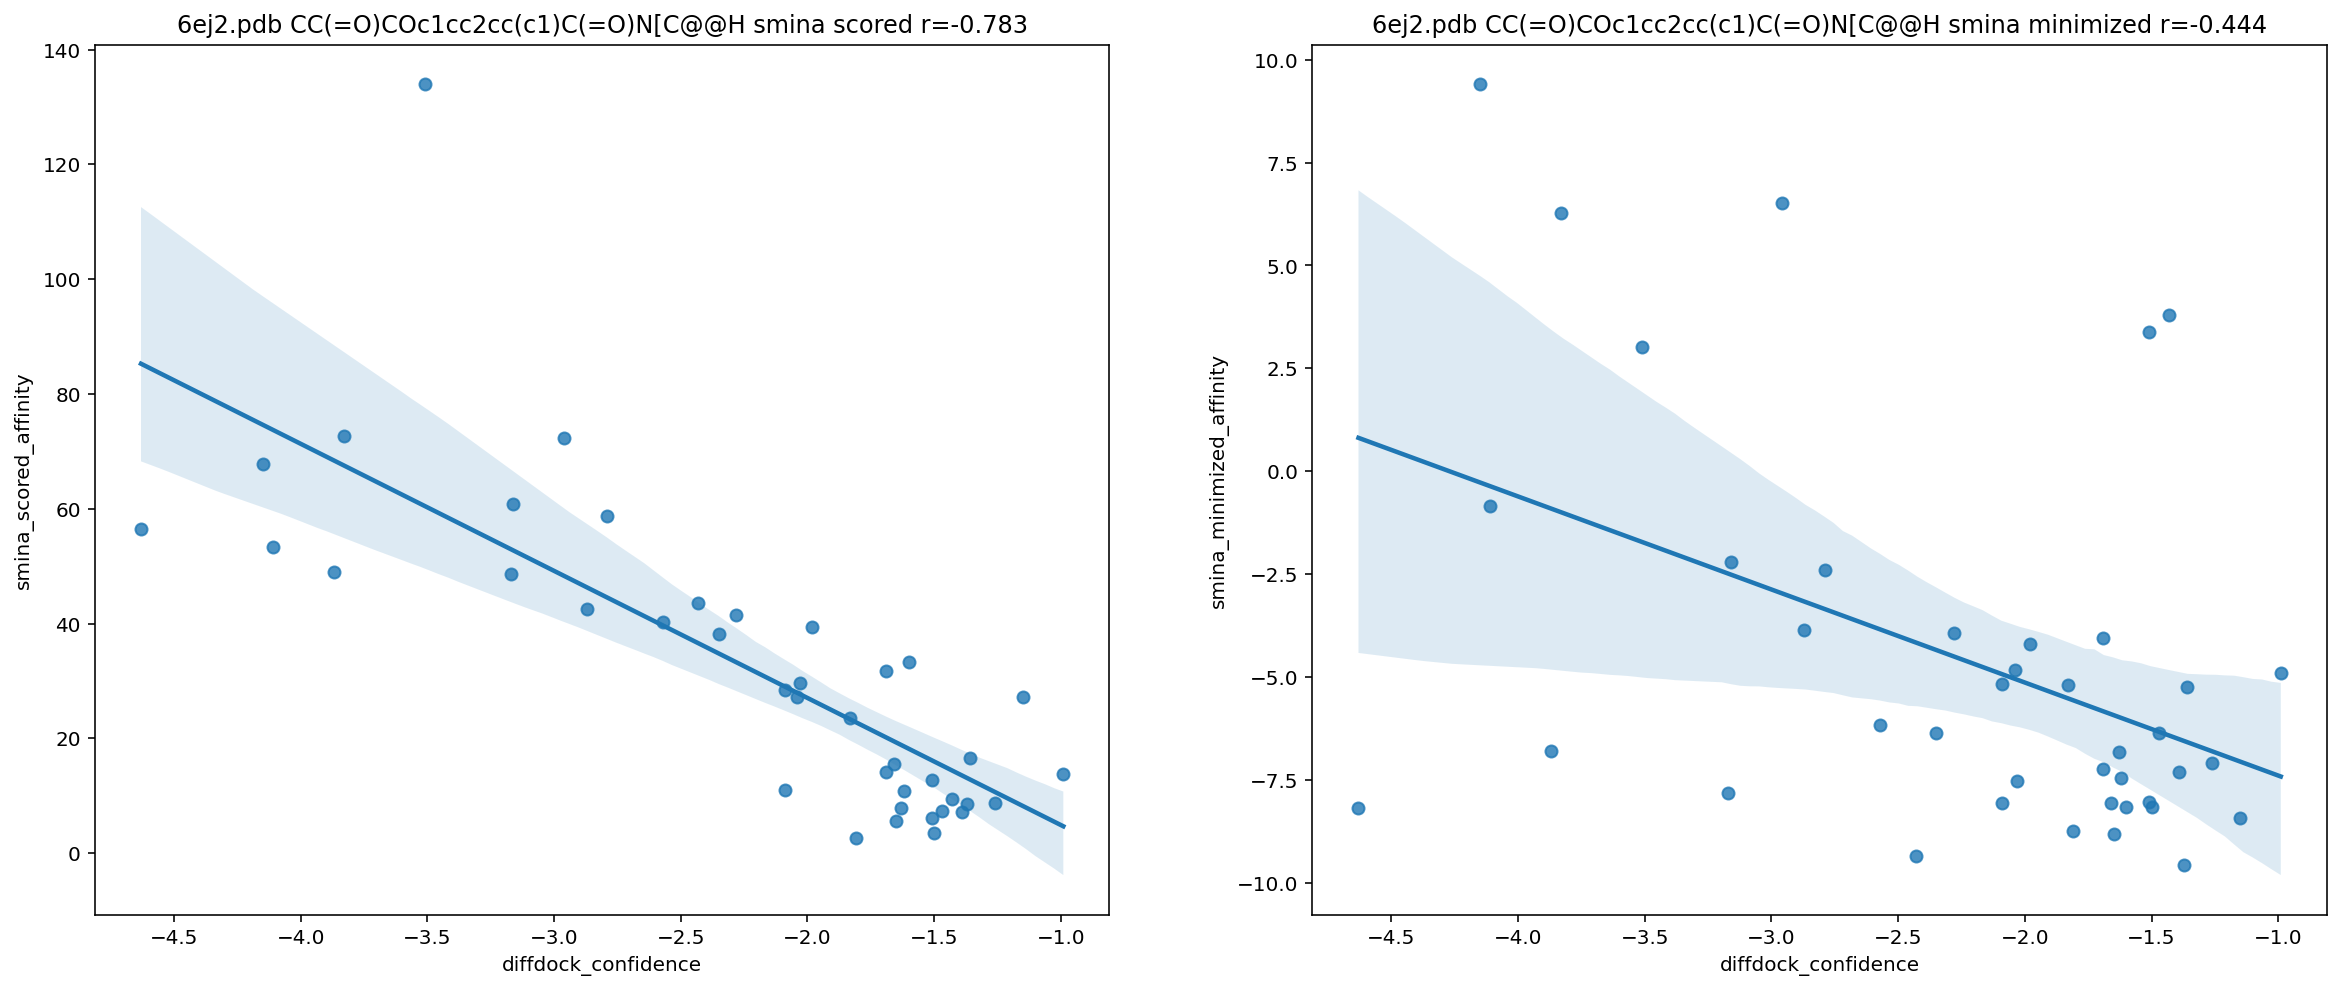

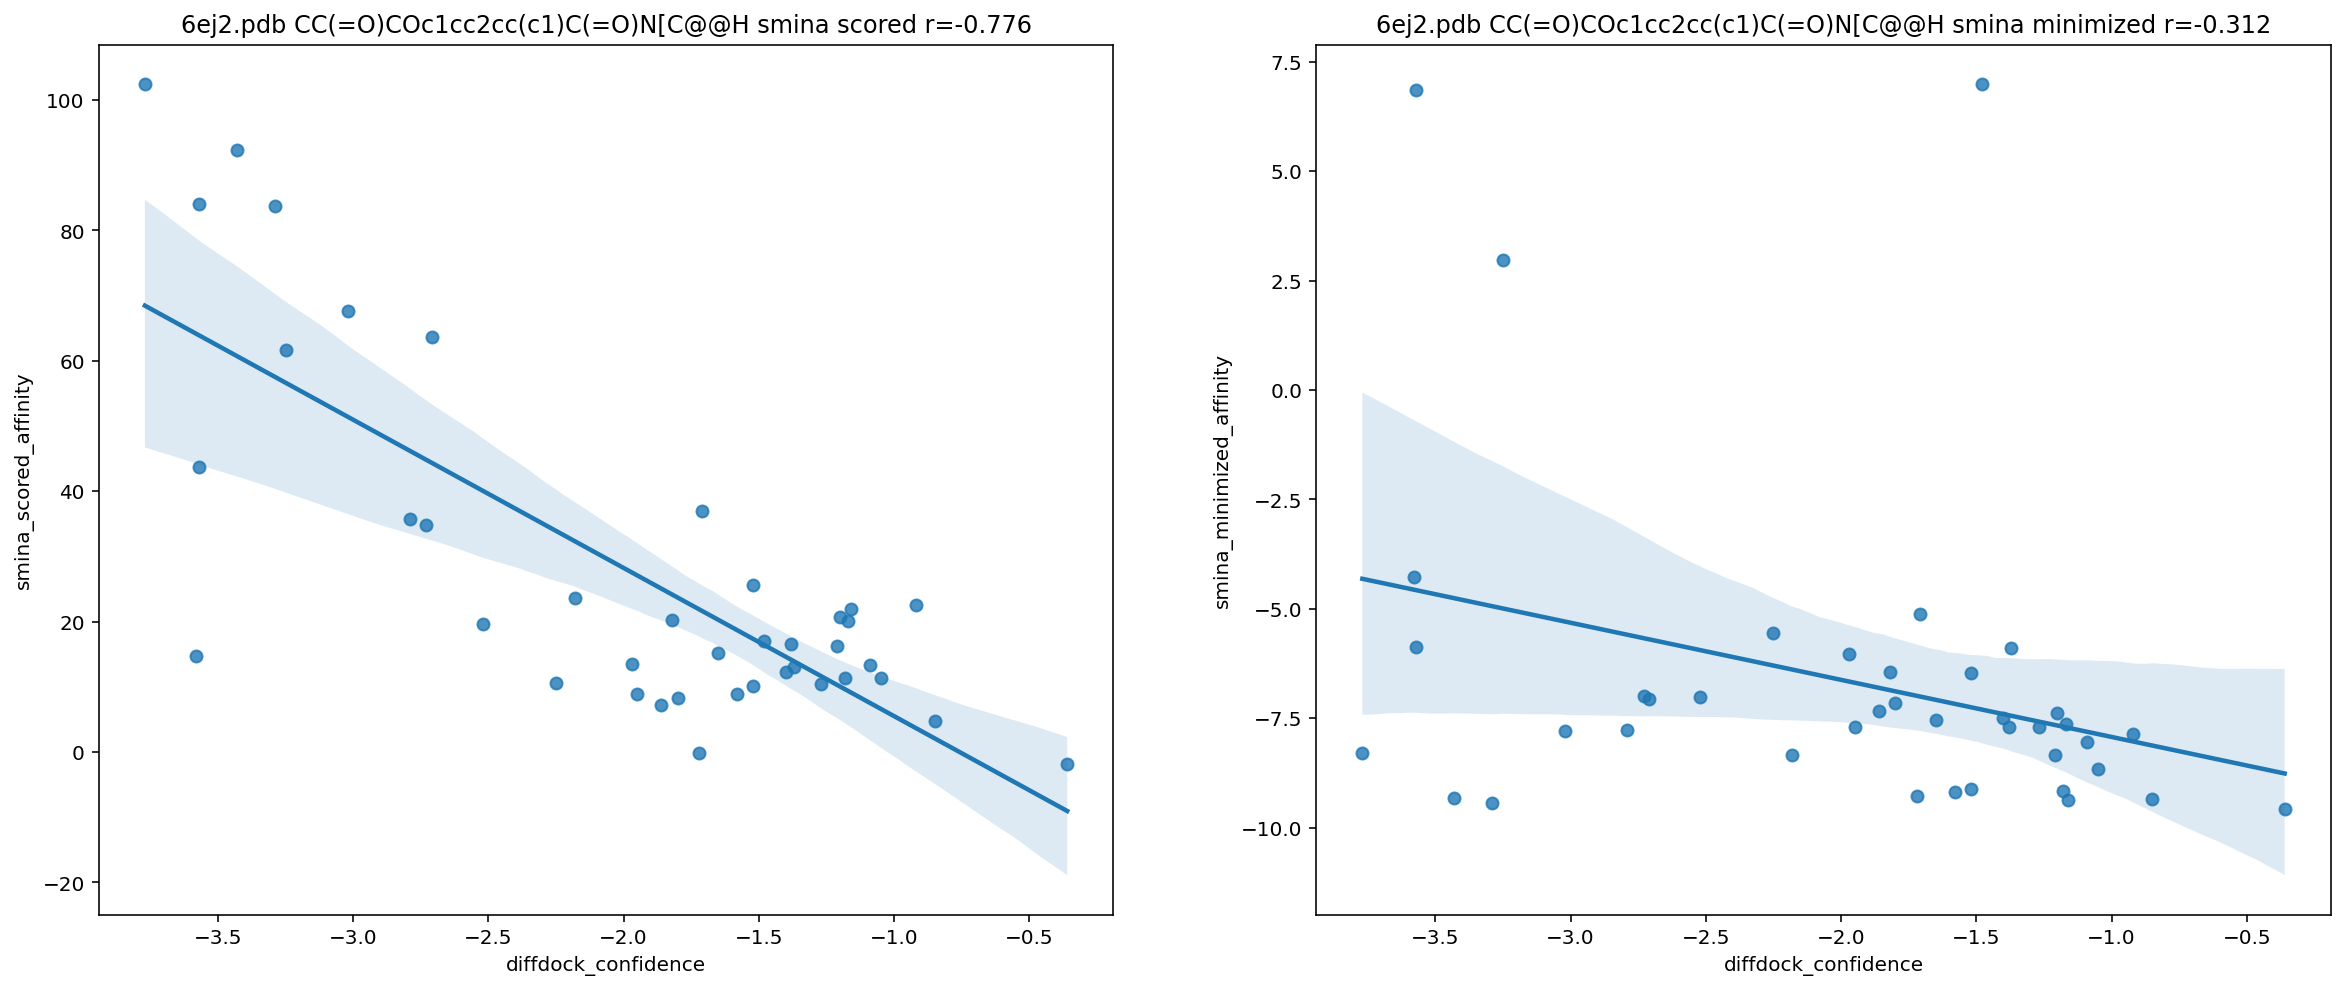

Error in callback <function flush_figures at 0x7f4297c919d0> (for post_execute):


KeyboardInterrupt: ignored

time: 22.6 s (started: 2022-12-18 20:00:57 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="smina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="smina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["smina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["smina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} smina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} smina minimized r={r_value_minimized:.3f}");

In [ ]:
df_results.sort_values("diffdock_confidence", ascending=False)

,pdb_file,smiles,diffdock_confidence,smina_scored_affinity,smina_minimized_affinity,sdf_file
5874,6ej2.pdb,C[C@@H]1CCCCCCCCC(=O)N(C)[C@@H](C)C(=O)N[C@@H]...,0.75,-4.16010,-7.46602,./index138_-tmp-pdb-6ej2.pdb____C[C@@H]1CCCCCC...
5858,6ej2.pdb,C[C@@H]1CCCCCCCCC(=O)N(C)[C@@H](C)C(=O)N[C@@H]...,0.74,-6.30784,-7.20774,./index138_-tmp-pdb-6ej2.pdb____C[C@@H]1CCCCCC...
5855,6ej2.pdb,C[C@@H]1CCCCCCCCC(=O)N(C)[C@@H](C)C(=O)N[C@@H]...,0.72,-5.17228,-6.68743,./index138_-tmp-pdb-6ej2.pdb____C[C@@H]1CCCCCC...
5873,6ej2.pdb,C[C@@H]1CCCCCCCCC(=O)N(C)[C@@H](C)C(=O)N[C@@H]...,0.69,-3.42014,-6.88817,./index138_-tmp-pdb-6ej2.pdb____C[C@@H]1CCCCCC...
5849,6ej2.pdb,C[C@@H]1CCCCCCCCC(=O)N(C)[C@@H](C)C(=O)N[C@@H]...,0.68,-5.70807,-7.01299,./index138_-tmp-pdb-6ej2.pdb____C[C@@H]1CCCCCC...
...,...,...,...,...,...,...
2360,6ej2.pdb,C[C@@H]2CCOCCCCNc1cc(cc(C)n1)C(=O)N[C@@H](C2)[...,-4.87,27.85361,-5.40746,./index43_-tmp-pdb-6ej2.pdb____C[C@@H]2CCOCCCC...
3663,6ej2.pdb,COCc1cc3cc(c1)C(=O)N[C@@H](Cc2cc(ccc2)OCCCCN3)...,-5.06,59.45660,9.98821,./index119_-tmp-pdb-6ej2.pdb____COCc1cc3cc(c1)...
4563,6ej2.pdb,CC(C)c4ccnc(CNC[C@@H](O)[C@@H]3Cc1cccc(c1)OCCC...,-5.16,75.15453,31.91187,./index134_-tmp-pdb-6ej2.pdb____CC(C)c4ccnc(CN...
4119,6ej2.pdb,C[C@@H]2CC-C=C-CCCNc1cc(cc(CO)c1)C(=O)N[C@@H](...,-5.29,35.14498,-8.28171,./index62_-tmp-pdb-6ej2.pdb____C[C@@H]2CC-C=C-...


time: 16.7 ms (started: 2022-12-18 20:01:40 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

time: 21.9 s (started: 2022-12-18 20:02:29 +00:00)
